In [1]:
import json
import itertools
import numpy as np
from scipy.stats import ks_2samp

In [2]:
def load_json_file(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

In [3]:
class PoolElement:
    """
    Represents a single entry in a pool with a name and associated file path.
    """
    def __init__(self, name, path, description=""):
        self.name = name
        self.path = path
        self.description = description
        self.results = load_json_file(path)
    
    def __repr__(self) -> str:
        return f"""PoolElement: {self.name}""" + (": {self.description}" if self.description!="" else "")


class Pool:
    """
    Represents a collection of PoolEntry objects.
    """
    def __init__(self, name, elements_cfgs):
        """
        Initializes the pool with a dictionary of name-path mappings.
        """
        self.name = name
        self.elements = {cfg['name']: PoolElement(**cfg) for name, cfg in elements_cfgs.items()}
        assert len(self.elements) == len(elements_cfgs)
        
    
    def add_elemens(self, element_cfgs):
        for name, cfg in element_cfgs.items():
            assert name not in self.elements
            self.elements[cfg['name']] == PoolElement(**cfg)
    
    
    def __repr__(self) -> str:
        return f"""Pool: {self.name}"""
    

class DecisionMetricTemplate:
    def __init__(self, name):
        self.name = name

    def decide(self, stats, agnostic_stats)-> tuple[bool, float]:
        pass


class DecisionEvaluator:
    def __init__(self, familiar_pool, agnostic_pool):
        self.agnostic_pool = agnostic_pool
        self.familiar_pool = familiar_pool
    
    def evaluate(self, decision_metric):
        agnostic_dct = {}
        familiar_dct = {}
        for key1 in self.agnostic_pool.elements.keys():
            for key2 in self.agnostic_pool.elements.keys():
                stats = self.agnostic_pool.elements[key1].results
                agnostic_stats = self.agnostic_pool.elements[key2].results
                decision, score = decision_metric.decide(stats, agnostic_stats)
                if key1 not in agnostic_dct:
                    agnostic_dct[key1] = {}
                
                # Assign decision and score for key2
                agnostic_dct[key1][key2] = {
                    "decision": decision,
                    "score": score
                }
        
        for key1 in self.familiar_pool.elements.keys():
            for key2 in self.agnostic_pool.elements.keys():
                stats = self.familiar_pool.elements[key1].results
                agnostic_stats = self.agnostic_pool.elements[key2].results
                decision, score = decision_metric.decide(stats, agnostic_stats)
                if key1 not in familiar_dct:
                    familiar_dct[key1] = {}
                
                familiar_dct[key1][key2] = {
                    "decision": decision,
                    "score": score
                }
                
        return agnostic_dct, familiar_dct

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grid_with_numbers(data_dict, title, grid_type):
    """
    Plots a grid with numbers displayed in each cell for the given data_dict.
    
    Parameters:
    - data_dict: The dictionary containing nested dictionaries with 'decision' and 'score'.
    - title: The title of the plot.
    - grid_type: Either 'decision' or 'score'.
    """
    keys1 = list(data_dict.keys())  # Row labels
    keys2 = list(next(iter(data_dict.values())).keys())  # Column labels

    # Prepare the grid data
    grid_data = []
    for key1 in keys1:
        row = []
        for key2 in keys2:
            row.append(data_dict[key1][key2][grid_type])
        grid_data.append(row)
    
    grid_data = np.array(grid_data)

    # Create a figure
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(grid_data, cmap="coolwarm" if grid_type == "score" else "Greens", aspect="auto")

    # Add numbers inside the grid
    for i in range(len(keys1)):
        for j in range(len(keys2)):
            if isinstance(grid_data[i, j], (int, np.integer)):  # Integer for decisions
                text = str(grid_data[i, j])
            elif grid_data[i, j] < 0.01:  # Scientific notation for small scores
                text = f"{grid_data[i, j]:.1e}"
            else:  # Standard decimal format for scores
                text = f"{grid_data[i, j]:.2f}"
            text = f"{text}" if grid_type == "score" else str(text)
            ax.text(j, i, text, ha="center", va="center", color="black")

    # Add labels and title
    ax.set_xticks(np.arange(len(keys2)))
    ax.set_yticks(np.arange(len(keys1)))
    ax.set_xticklabels(keys2, rotation=90)
    ax.set_yticklabels(keys1)
    ax.set_title(f"{title} ({grid_type.capitalize()})", fontsize=14)
    plt.colorbar(im, ax=ax, label=grid_type.capitalize())
    plt.xlabel("Key2")
    plt.ylabel("Key1")
    plt.tight_layout()
    plt.show()

def visualize_decision_and_score_with_numbers(agnostic_dct, familiar_dct):
    """
    Visualizes two grids (decision and score) for both agnostic_dct and familiar_dct, 
    with numbers displayed in each cell.
    
    Parameters:
    - agnostic_dct: Dictionary with decisions and scores for the agnostic pool.
    - familiar_dct: Dictionary with decisions and scores for the familiar pool.
    """
    # Plot for agnostic dictionary
    # plot_grid_with_numbers(agnostic_dct, "Agnostic Pool", "decision")
    plot_grid_with_numbers(agnostic_dct, "Agnostic Pool", "score")
    
    # Plot for familiar dictionary
    # plot_grid_with_numbers(familiar_dct, "Familiar Pool", "decision")
    plot_grid_with_numbers(familiar_dct, "Familiar Pool", "score")

In [5]:
FAMILIAR_POOL_DICT = {
    "llama3.2-3b-inst_lr2e-5_wd0.01_tofu_full": {
        "path": "/scratch/workspace/amekala_umass_edu-unlearning/Vineeth/TOFU_V2/UnlearningFactory/saves/train/llama3.2-3b-inst_lr2e-5_wd0.01_tofu_full/2024-11-20_00-20-15/checkpoint-1250/evals/TOFU_EVAL.json",
        "name": "lr2e-5_full_epoch10"
    },
    "llama3.2-3b-inst_lr5e-5_wd0.01_tofu_full_epoch5": {
        "path": "/scratch/workspace/amekala_umass_edu-unlearning/Vineeth/TOFU_V2/UnlearningFactory/saves/train/llama3.2-3b-inst_lr5e-5_wd0.01_tofu_full/2024-11-20_00-20-15/checkpoint-625/evals/TOFU_EVAL.json",
        "name": "lr5e-5_full_epoch5"
    },
    "llama3.2-3b-inst_lr5e-5_wd0.01_tofu_full": {
        "path": "/scratch/workspace/amekala_umass_edu-unlearning/Vineeth/TOFU_V2/UnlearningFactory/saves/train/llama3.2-3b-inst_lr5e-5_wd0.01_tofu_full/2024-11-20_00-20-15/checkpoint-1250/evals/TOFU_EVAL.json",
        "name": "lr5e-5_full_epoch10"
    },
    # "llama3.2-3b-inst_unl_adv_GradDiff_gamma0.1_lr5e-5_wd0.01_tofu_full": {
    #     "path": "/scratch/workspace/amekala_umass_edu-unlearning/Vineeth/TOFU_V2/UnlearningFactory/saves/unlearn/llama3.2-3b-inst_unl_adv_GradDiff_gamma0.1_lr5e-5_wd0.01_tofu_full/2024-11-21_04-13-45/checkpoint-1120/evals/TOFU_EVAL.json",
    # },
    "llama3.2-3b-inst_unl_adv_GradDiff_gamma0.05_lr5e-5_wd0.01_tofu_full": {
        "path": "/scratch/workspace/amekala_umass_edu-unlearning/Vineeth/TOFU_V2/UnlearningFactory/saves/unlearn/llama3.2-3b-inst_unl_adv_GradDiff_gamma0.05_lr5e-5_wd0.01_tofu_full/2024-11-21_04-13-45/checkpoint-1120/evals/TOFU_EVAL.json",
        "name": "GD_g0.05_lr5e-5_full_epoch10"
    },
    # "llama3.2-3b-inst_unl_adv_NPO_gamma0.1_lr5e-5_wd0.01_tofu_full": {
    #     "path": "/scratch/workspace/amekala_umass_edu-unlearning/Vineeth/TOFU_V2/UnlearningFactory/saves/unlearn/llama3.2-3b-inst_unl_adv_NPO_gamma0.1_lr5e-5_wd0.01_tofu_full/2024-11-21_04-13-45/checkpoint-1120/evals/TOFU_EVAL.json",
    # },
    "llama3.2-3b-inst_unl_adv_NPO_gamma0.05_lr5e-5_wd0.01_tofu_full": {
        "path": "/scratch/workspace/amekala_umass_edu-unlearning/Vineeth/TOFU_V2/UnlearningFactory/saves/unlearn/llama3.2-3b-inst_unl_adv_NPO_gamma0.05_lr5e-5_wd0.01_tofu_full/2024-11-21_04-13-45/checkpoint-1120/evals/TOFU_EVAL.json",
        "name": "npo_g0.05_lr5e-5_full_epoch10"
    },
    "llama3.2-3b-inst_unl_adv_GradDiff_idk_gamma-0.005_lr5e-5_wd0.01_tofu_full": {
        "path": "/scratch/workspace/amekala_umass_edu-unlearning/Vineeth/TOFU_V2/UnlearningFactory/saves/unlearn/llama3.2-3b-inst_unl_adv_GradDiff_idk_gamma-0.005_lr5e-5_wd0.01_tofu_full/2024-11-22_19-10-14/checkpoint-1120/evals/TOFU_EVAL.json",
        "name": "GD_idk_gamma-0.005_lr5e-5_full"
    }
}


AGNOSTIC_POOL_DICT = {
    "llama3.2-3b-inst_lr2e-5_wd0.01_tofu_retain90": {
        "path": "/scratch/workspace/amekala_umass_edu-unlearning/Vineeth/TOFU_V2/UnlearningFactory/saves/train/llama3.2-3b-inst_lr2e-5_wd0.01_tofu_retain90/2024-11-20_00-20-03/checkpoint-1120/evals/TOFU_EVAL.json",
        "name": "lr2e-5_retain90_epoch10"
    },
    "llama3.2-3b-inst_lr5e-5_wd0.01_tofu_retain90_epoch_5": {
        "path": "/scratch/workspace/amekala_umass_edu-unlearning/Vineeth/TOFU_V2/UnlearningFactory/saves/train/llama3.2-3b-inst_lr5e-5_wd0.01_tofu_retain90/2024-11-20_00-20-03/checkpoint-562/evals/TOFU_EVAL.json",
        "name": "lr5e-5_retain90_epoch5"
    },
    "llama3.2-3b-inst_lr5e-5_wd0.01_tofu_retain90": {
        "path": "/scratch/workspace/amekala_umass_edu-unlearning/Vineeth/TOFU_V2/UnlearningFactory/saves/train/llama3.2-3b-inst_lr5e-5_wd0.01_tofu_retain90/2024-11-20_00-20-03/checkpoint-1120/evals/TOFU_EVAL.json",
        "name": "lr5e-5_retain90_epoch10"
    }
}


FAMILIAR_POOL = Pool("familiar", FAMILIAR_POOL_DICT)
AGNOSTIC_POOL = Pool("agnostic", AGNOSTIC_POOL_DICT)

EVALUATOR = DecisionEvaluator(FAMILIAR_POOL, AGNOSTIC_POOL)


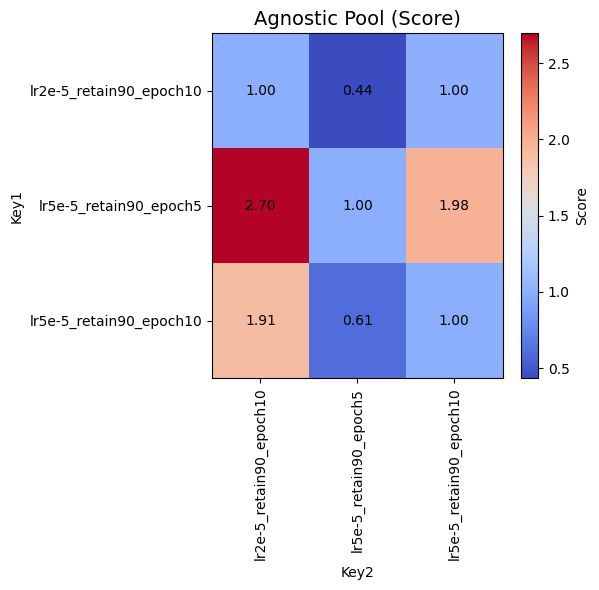

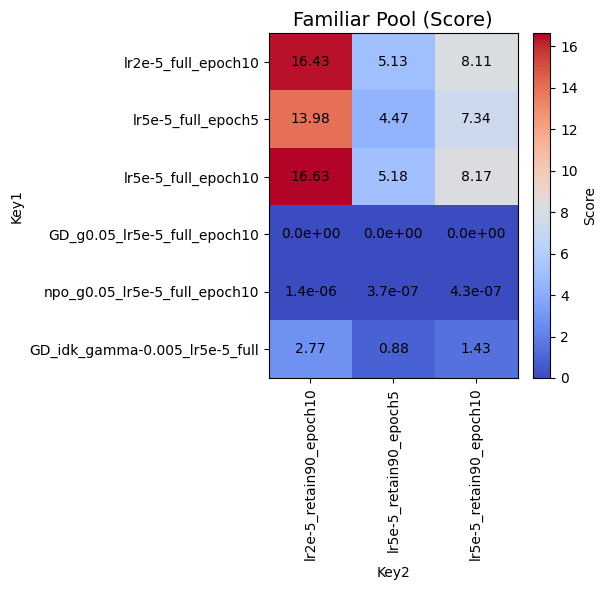

In [6]:
class ProbCompare(DecisionMetricTemplate):
    def __init__(self, metric_name, threshold=None):
        self.metric_name = metric_name 
        self.threshold = threshold
    
    def decide(self, stats, agnostic_stats)->bool:
        stats = stats[self.metric_name]
        agnostic_stats = agnostic_stats[self.metric_name]
        # return stats["agg_value"] >  agnostic_stats["agg_value"], stats["agg_value"]/agnostic_stats["agg_value"]
        score = np.mean([np.mean(stats["value_by_index"][str(i)]["prob"])/np.mean(agnostic_stats["value_by_index"][str(i)]["prob"]) for i in range(len(stats))])
        return score<1.2 and score>0.8, score

agnostic_dct, familiar_dct = EVALUATOR.evaluate(ProbCompare(metric_name="forget_Q_A_Prob"))
visualize_decision_and_score_with_numbers(agnostic_dct, familiar_dct)

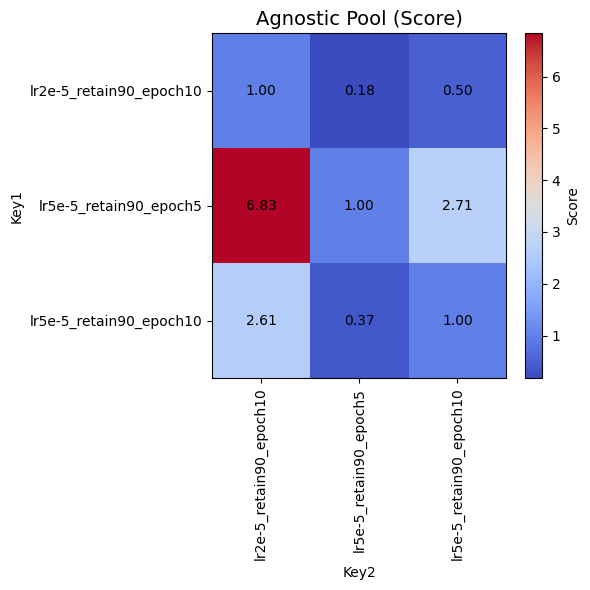

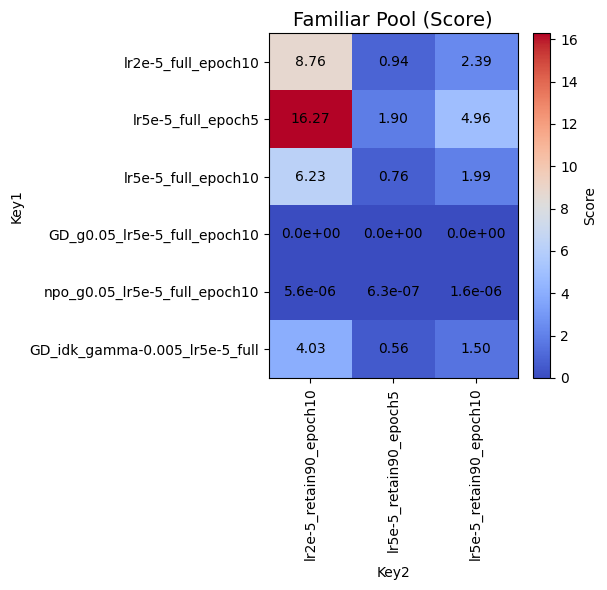

In [7]:
agnostic_dct, familiar_dct = EVALUATOR.evaluate(ProbCompare(metric_name="forget_Q_A_PARA_Prob"))
visualize_decision_and_score_with_numbers(agnostic_dct, familiar_dct)

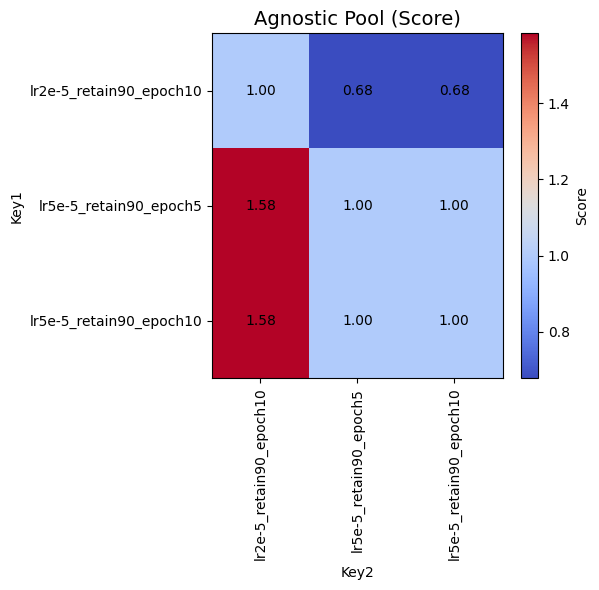

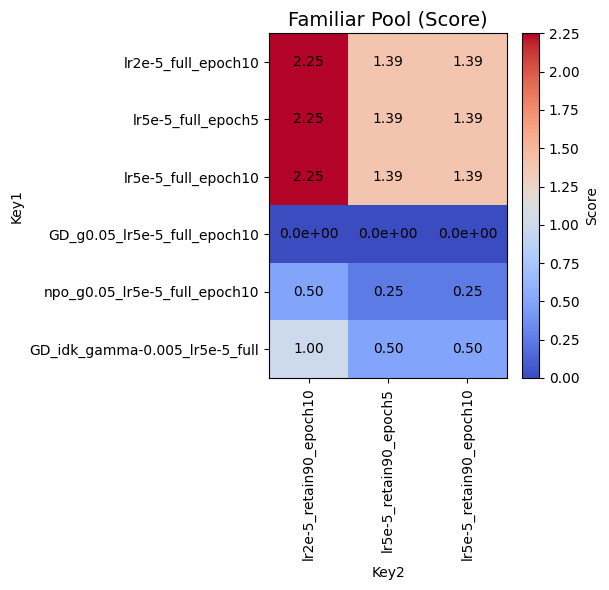

In [8]:
class RougeCompare(DecisionMetricTemplate):
    def __init__(self, metric_name, threshold=None):
        self.metric_name = metric_name 
        self.threshold = threshold
    
    def decide(self, stats, agnostic_stats)->bool:
        stats = stats[self.metric_name]
        agnostic_stats = agnostic_stats[self.metric_name]
        # return stats["agg_value"] >  agnostic_stats["agg_value"], stats["agg_value"]/agnostic_stats["agg_value"]
        score = np.mean([np.mean(stats["value_by_index"][str(i)]["rougeL_recall"])/np.mean(agnostic_stats["value_by_index"][str(i)]["rougeL_recall"]) for i in range(len(stats))])
        return score<1.2 and score>0.8, score

agnostic_dct, familiar_dct = EVALUATOR.evaluate(RougeCompare(metric_name="forget_Q_A_ROUGE"))
visualize_decision_and_score_with_numbers(agnostic_dct, familiar_dct)

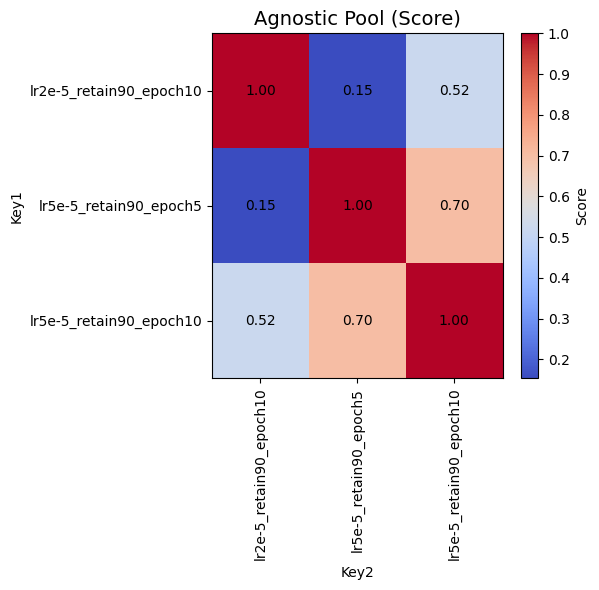

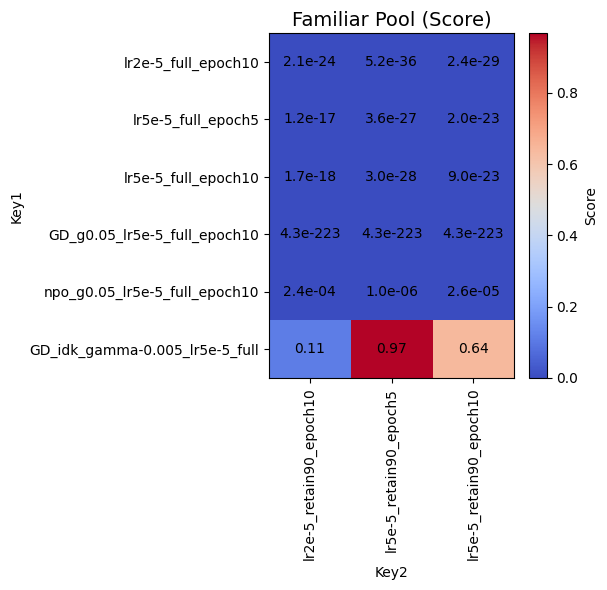

In [9]:
class ForgetQuality(DecisionMetricTemplate):
    def __init__(self, metric_name, threshold=None):
        self.metric_name = metric_name 
        self.threshold = threshold
    
    def decide(self, stats, agnostic_stats)->bool:
        stats = stats[self.metric_name]
        agnostic_stats = agnostic_stats[self.metric_name]
        stats_truth_ratio = [x['truth_ratio'] for idx, x in stats["value_by_index"].items()]
        agnostic_truth_ratio =  [x['truth_ratio'] for idx, x in agnostic_stats["value_by_index"].items()]
        test_res = ks_2samp(stats_truth_ratio, agnostic_truth_ratio)
        # {'Forget Quality': test_res.pvalue, 'KS Test PVal Forget': test_res.pvalue, 'KS Test Forget': test_res.statistic}
        score = test_res.pvalue
        decision = score<self.threshold
        return decision, score

agnostic_dct, familiar_dct = EVALUATOR.evaluate(ForgetQuality(metric_name="forget_truth_ratio", threshold=0.05))
visualize_decision_and_score_with_numbers(agnostic_dct, familiar_dct)

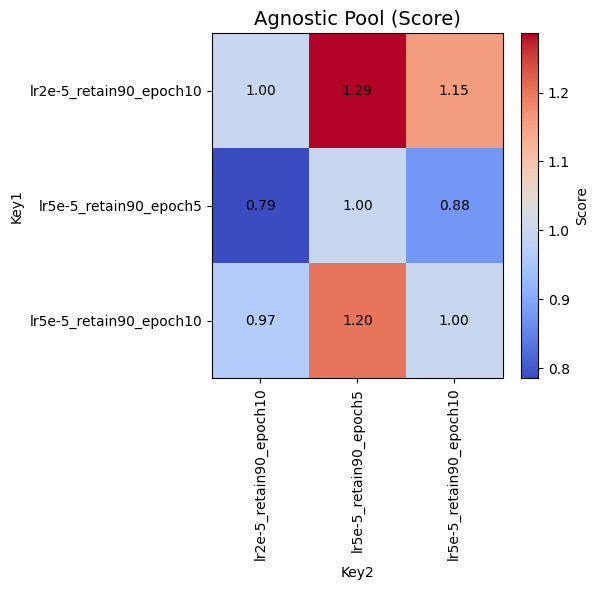

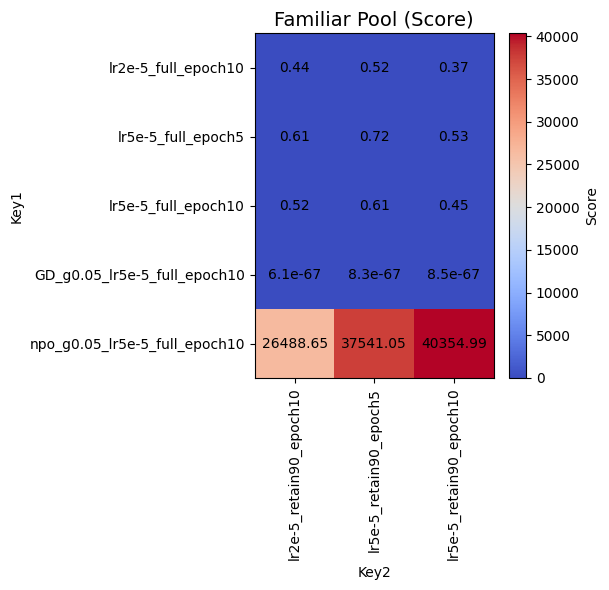

In [11]:
class TruthRatioCompare(DecisionMetricTemplate):
    def __init__(self, metric_name, threshold=None):
        self.metric_name = metric_name 
        self.threshold = threshold
    
    def decide(self, stats, agnostic_stats)->bool:
        stats = stats[self.metric_name]
        agnostic_stats = agnostic_stats[self.metric_name]
        # return stats["agg_value"] >  agnostic_stats["agg_value"], stats["agg_value"]/agnostic_stats["agg_value"]
        score = np.mean([np.mean(stats["value_by_index"][str(i)]["truth_ratio"])/np.mean(agnostic_stats["value_by_index"][str(i)]["truth_ratio"]) for i in range(len(stats))])
        return score<1.2 and score>0.8, score

agnostic_dct, familiar_dct = EVALUATOR.evaluate(TruthRatioCompare(metric_name="forget_truth_ratio"))
visualize_decision_and_score_with_numbers(agnostic_dct, familiar_dct)

In [44]:
get_forget_quality(RETAIN_POOL_RESULTS["llama3.2-3b-inst_lr2e-5_wd0.01_tofu_retain90"], RETAIN_POOL_RESULTS["llama3.2-3b-inst_lr5e-5_wd0.01_tofu_retain90_epoch_5"])

{'Forget Quality': np.float64(0.15461291961180293),
 'KS Test PVal Forget': np.float64(0.15461291961180293),
 'KS Test Forget': np.float64(0.08)}

In [45]:
get_forget_quality(RETAIN_POOL_RESULTS["llama3.2-3b-inst_lr2e-5_wd0.01_tofu_retain90"], RETAIN_POOL_RESULTS["llama3.2-3b-inst_lr5e-5_wd0.01_tofu_retain90"])

{'Forget Quality': np.float64(0.5234101030810641),
 'KS Test PVal Forget': np.float64(0.5234101030810641),
 'KS Test Forget': np.float64(0.0575)}

In [48]:
get_forget_quality(FAMILIAR_POOL_RESULTS["llama3.2-3b-inst_unl_adv_lr5e-5_wd0.01_tofu_full"], RETAIN_POOL_RESULTS["llama3.2-3b-inst_lr5e-5_wd0.01_tofu_retain90"])

{'Forget Quality': np.float64(4.444317561110093e-89),
 'KS Test PVal Forget': np.float64(4.444317561110093e-89),
 'KS Test Forget': np.float64(0.6825)}

{'forget_Q_A_PARA_Prob': {'agg_value': 0.04277178175398148,
  'value_by_index': {'0': {'prob': 0.026633184403181076,
    'avg_loss': 3.6255972385406494},
   '1': {'prob': 0.014728521928191185, 'avg_loss': 4.2179694175720215},
   '2': {'prob': 0.052657246589660645, 'avg_loss': 2.943951368331909},
   '3': {'prob': 0.05879342555999756, 'avg_loss': 2.8337252140045166},
   '4': {'prob': 0.028790557757019997, 'avg_loss': 3.5477077960968018},
   '5': {'prob': 0.06468057632446289, 'avg_loss': 2.7382943630218506},
   '6': {'prob': 0.008752476423978806, 'avg_loss': 4.7384185791015625},
   '7': {'prob': 0.04746831953525543, 'avg_loss': 3.0476927757263184},
   '8': {'prob': 0.03979919105768204, 'avg_loss': 3.2239086627960205},
   '9': {'prob': 0.0193845983594656, 'avg_loss': 3.9432764053344727},
   '10': {'prob': 0.046244699507951736, 'avg_loss': 3.073808431625366},
   '11': {'prob': 0.030809812247753143, 'avg_loss': 3.47992205619812},
   '12': {'prob': 0.026980644091963768, 'avg_loss': 3.61263561

In [23]:
# Example dictionary
my_dict = {
    'a': 1,
    'b': 2,
    'c': 3,
    'd': 4
}

# Iterating over unique pairs of keys
for key1, key2 in itertools.combinations(my_dict.keys(), 2):
    print(f"Pair: ({key1}, {key2}) - Values: ({my_dict[key1]}, {my_dict[key2]})")

Pair: (a, b) - Values: (1, 2)
Pair: (a, c) - Values: (1, 3)
Pair: (a, d) - Values: (1, 4)
Pair: (b, c) - Values: (2, 3)
Pair: (b, d) - Values: (2, 4)
Pair: (c, d) - Values: (3, 4)
